**Carbon Intensity -- Average + Marginal Data**

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

sns.set_theme(style='ticks', context='paper')

In [136]:
# Constants
avg_cols = ['date','hour','day','month','weekday','ci']
marg_cols = ['date','hour','ci']
region_prefixes = ['gb', 'de', 'ca', 'tx', 'za', 'tyo', 'nsw']
regions = ['Great Britain', 'Germany', 'California', 'Texas', 'South Africa', 'Tokyo', 'New South Wales']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
short_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months_num = range(1,13)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
weekends = ['Saturday', 'Sunday']
short_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon']
gb_shift = -1
de_shift = -2
ca_shift = 7
tx_shift = 5
zaf_shift = -2
tyo_shift = -9
nsw_shift = -9
shifts = [gb_shift, de_shift, ca_shift, tx_shift, zaf_shift, tyo_shift, nsw_shift]  # according to BST now (UTC+1)
season_names = ['Winter', 'Spring', 'Summer', 'Autumn']
short_seasons = ['spr', 'sum', 'aut', 'win']

In [5]:
# Functions
def load_df(region, year, ci_type):
    if ci_type == 'avg':
        df = pd.read_csv(f'../data/intensity/avg-{region}-{year}.csv', names=avg_cols, skiprows=1)
    else:
        df = pd.read_csv(f'../data/intensity/marg-{region}-{year}.csv', names=marg_cols, skiprows=1)
        df[['year', 'month', 'day']] = df['date'].str.split('-', n=2, expand=True)

    df_ci = df[['date', 'hour', 'ci']]
    df_ci = df_ci.rename(columns={'ci': region + '_ci'})

    return (df, df_ci)

def shift_by_timezone(data, shift):
    shifted = pd.concat([data[shift:], data[:shift]])
    shifted['hour'] = data['hour']
    return shifted

In [6]:
# Average CI Data -- from Electricity Maps

# 2024
(gb, gb_ci) = load_df('gb', '2024', 'avg')  # Great Britain
(de, de_ci) = load_df('de', '2024', 'avg')  # Germany
(ca, ca_ci) = load_df('ca', '2024', 'avg')  # California
(tx, tx_ci) = load_df('tx', '2024', 'avg')  # Texas
(zaf, zaf_ci) = load_df('zaf', '2024', 'avg')  # South Africa
(tyo, tyo_ci) = load_df('tyo', '2024', 'avg')  # Tokyo
(nsw, nsw_ci) = load_df('nsw', '2024', 'avg')  # New South Wales

all_2024_avg_data = pd.concat([gb_ci, de_ci, ca_ci, tx_ci, zaf_ci, tyo_ci, nsw_ci], axis=1)
all_2024_avg_data.describe()

,gb_ci,de_ci,ca_ci,tx_ci,zaf_ci,tyo_ci,nsw_ci
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,105.687816,275.124187,168.426444,301.854707,656.719498,452.669816,500.155390
std,54.942573,111.280334,75.313022,79.434659,31.210846,68.287553,147.710867
min,7.700000,66.850000,20.190000,99.530000,547.830000,140.510000,129.010000
25%,60.955000,180.865000,103.237500,243.527500,634.830000,414.535000,380.847500
50%,94.525000,273.190000,177.495000,300.610000,658.475000,493.680000,547.050000
75%,143.377500,359.952500,235.060000,360.155000,680.572500,498.850000,618.405000
max,277.980000,563.230000,325.640000,486.480000,740.720000,508.340000,748.000000


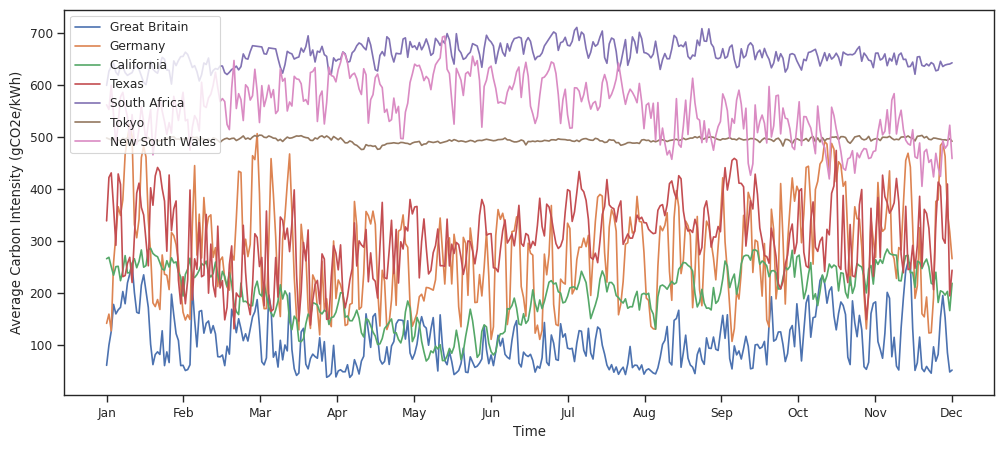

In [7]:
# Plot Smoothed Regional Comparison
plt.figure(figsize=(12,5))
gb_ci.groupby(['date'])['gb_ci'].median().plot(label='Great Britain')
de_ci.groupby(['date'])['de_ci'].median().plot(label='Germany')
ca_ci.groupby(['date'])['ca_ci'].median().plot(label='California')
tx_ci.groupby(['date'])['tx_ci'].median().plot(label='Texas')
zaf_ci.groupby(['date'])['zaf_ci'].median().plot(label='South Africa')
tyo_ci.groupby(['date'])['tyo_ci'].median().plot(label='Tokyo')
nsw_ci.groupby(['date'])['nsw_ci'].median().plot(label='New South Wales')
plt.legend(loc='upper left')
plt.xticks(np.linspace(0,365,12), short_months)
plt.xlabel('Time')
plt.ylabel('Average Carbon Intensity (gCO2e/kWh)')
plt.show()

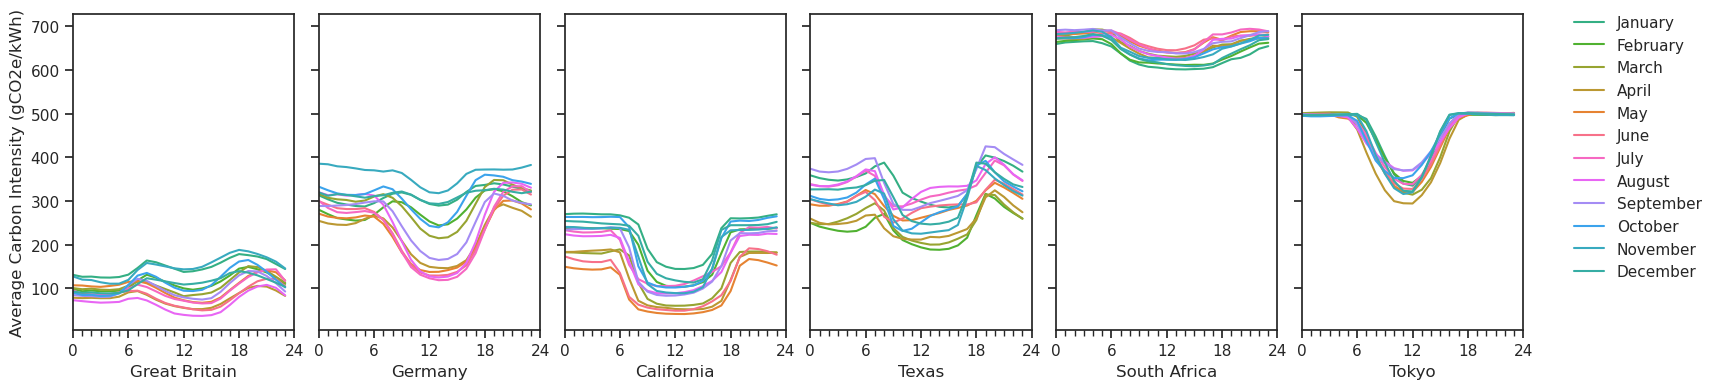

In [8]:
# Monthly Analysis
sns.set_theme(style='ticks')

f, axs = plt.subplots(ncols=6, nrows=1, sharey=True, sharex=True, figsize=(15,3.5))
f.tight_layout(pad=0)
palette = sns.palettes._ColorPalette(np.roll(np.flip(sns.color_palette("husl", 12), axis=0), 6, axis=0))

for ax, region, label, shift in zip(axs, [gb, de, ca, tx, zaf, tyo, nsw], regions, shifts):
    data_by_month = region.groupby('month', as_index=False, sort=False)

    for month_num, colour, month_name in zip(months_num, palette, months):
        month_data = data_by_month.get_group(month_num)
        avg_day_ci = month_data.groupby('hour', as_index=False, sort=False)['ci'].mean()
        shifted = shift_by_timezone(avg_day_ci, shift)
        ax.plot(avg_day_ci['hour'], shifted['ci'].values, color=colour, label=month_name)

    ax.set_xlabel(label)
    ax.set_xlim(0, 24)
    ticks = range(0, 25, 6)
    minor_ticks = range(0, 25)
    ax.set_xticks(ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels([f'{int(tick)}' for tick in ticks])

handles, labels = ax.get_legend_handles_labels()
f.legend(handles, months, loc='upper right', bbox_to_anchor=(1.12, 1.02), frameon=False)
axs[0].set(ylabel='Average Carbon Intensity (gCO2e/kWh)')

plt.savefig('../image/avg-ci-hist-by-month-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Plot Weekly Analysis with Windows of Low-Carbon Intensity Highlighted (!)
def plot_weekly_analysis_compare_all(window_width=8):
    # Weekly Analysis
    f, axs = plt.subplots(ncols=1, nrows=6, sharex=True, figsize=(6,6))
    f.tight_layout(pad=0)
    f.text(-0.075, 0.5, 'Average Carbon Intensity (gCO2e/kWh)', ha='center', va='center', rotation='vertical')

    # Plot Average Carbon Intensity w/ Error and Low-Carbon Windows for Each region
    for ax, region, label, shift in zip(axs, [gb, de, ca, tx, zaf, tyo, nsw], regions, shifts):
        data_by_weekday = region.groupby('weekday', as_index=False, sort=False)
        full_week_ci = []
        full_week_times = []
        full_week_err_low = []
        full_week_err_high = []
        full_week_medians = []

        for day, num in zip(days, range(0, 7)):
            day_data = data_by_weekday.get_group(day)
            avg_day_ci = day_data.groupby('hour', as_index=False, sort=False)['ci'].mean()
            avg_day_sem = day_data.groupby('hour', as_index=False, sort=False)['ci'].sem() 
            confidence_int = 1.96 * avg_day_sem['ci']
            ci_low = avg_day_ci['ci'] - confidence_int
            ci_high = avg_day_ci['ci'] + confidence_int
            time = avg_day_ci.index + (24 * num)

            full_week_ci = np.concatenate((full_week_ci, avg_day_ci['ci'].values))
            full_week_times = np.concatenate((full_week_times, time))
            full_week_err_low = np.concatenate((full_week_err_low, ci_low))
            full_week_err_high = np.concatenate((full_week_err_high, ci_high))

            full_week_medians.append(avg_day_ci['ci'].median())

        shifted_full_week = np.roll(full_week_ci, -shift)
        shifted_full_week_err_low = np.roll(full_week_err_low, -shift)
        shifted_full_week_err_high = np.roll(full_week_err_high, -shift)
        sns.lineplot(y=shifted_full_week, x=full_week_times, ax=ax)
        ax.fill_between(full_week_times, shifted_full_week_err_low, shifted_full_week_err_high, alpha=0.15)

        ax.set_ylabel(label)
        ax.set_xlim(0, 24 * 7)
        ticks = range(0, 24 * 7 + 1, 24)
        minor_ticks = range(0, 24 * 7 + 1, 6)
        ax.set_xticks(ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_xticklabels(short_days)

        # Plot Low Carbon Windows
        weekly_avg_median = sum(full_week_medians) / len(full_week_medians)
        peaks, props = find_peaks(-shifted_full_week, prominence=1, width=window_width, height=-weekly_avg_median)

        for left, right in zip(props['left_ips'], props['right_ips']):
            ax.axvspan(left, right, color='green', alpha=0.3)

    ax.set(xlabel="Weekday")
    f.align_ylabels()

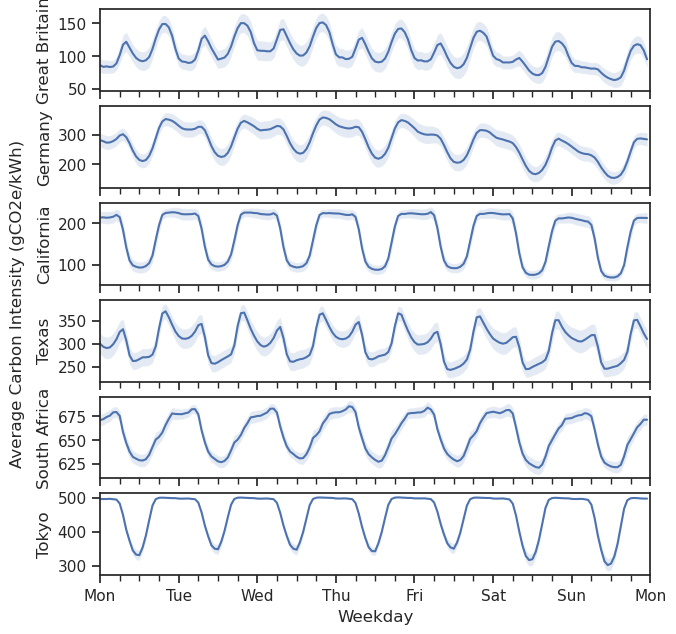

In [10]:
# Weekly Analysis
plot_weekly_analysis_compare_all(window_width=24)
plt.savefig('../image/avg-weekly-ci-pattern-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

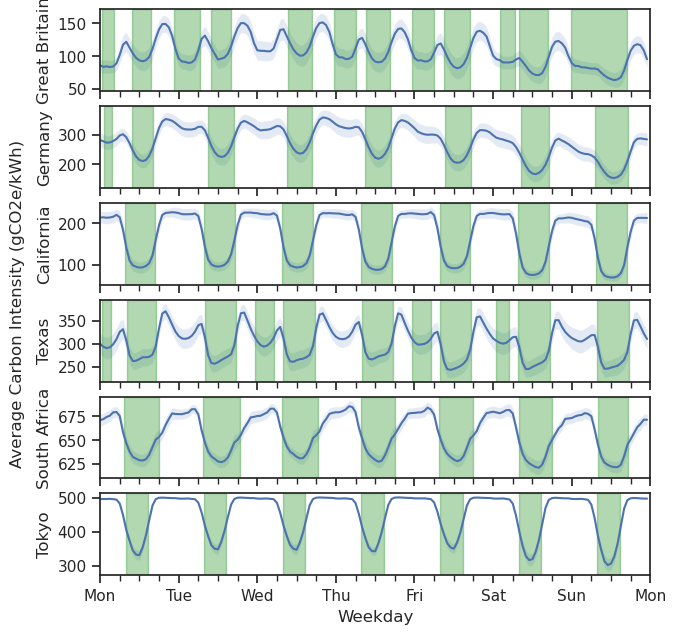

In [42]:
plot_weekly_analysis_compare_all(window_width=2)
plt.savefig('../image/avg-weekly-ci-windows-2024.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Marginal CI Data -- from WattTime

# 2024
(marg_gb, marg_gb_ci) = load_df('gb', '2024', 'marg')  # Great Britain
(marg_de, marg_de_ci) = load_df('de', '2024', 'marg')  # Germany
(marg_ca, marg_ca_ci) = load_df('ca', '2024', 'marg')  # California
(marg_tx, marg_tx_ci) = load_df('tx', '2024', 'marg')  # Texas
(marg_zaf, marg_zaf_ci) = load_df('zaf', '2024', 'marg')  # South Africa
(marg_tyo, marg_tyo_ci) = load_df('tyo', '2024', 'marg')  # Tokyo
(marg_nsw, marg_nsw_ci) = load_df('nsw', '2024', 'marg')  # New South Wales

all_2024_marg_data = pd.concat([marg_gb_ci, marg_de_ci, marg_ca_ci, marg_tx_ci, marg_zaf_ci, marg_tyo_ci, marg_nsw_ci], axis=1)
all_2024_marg_data.describe()

,gb_ci,de_ci,ca_ci,tx_ci,zaf_ci,tyo_ci,nsw_ci
count,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000
mean,416.654204,728.340662,370.532264,462.969040,887.394736,535.909198,727.380492
std,31.254897,181.420777,144.351175,168.646106,73.838813,0.262700,226.684173
min,316.153624,0.000000,31.751440,0.000000,399.614552,535.556074,0.000000
25%,386.913976,740.987891,416.397456,502.126344,920.338168,535.692152,770.199216
50%,412.224410,770.199216,432.726768,517.548472,920.338168,535.782870,798.775512
75%,435.539038,798.877570,444.973752,538.867296,920.383527,536.145744,821.330374
max,499.722306,869.535864,514.373328,589.216008,2618.994849,536.599336,876.339744


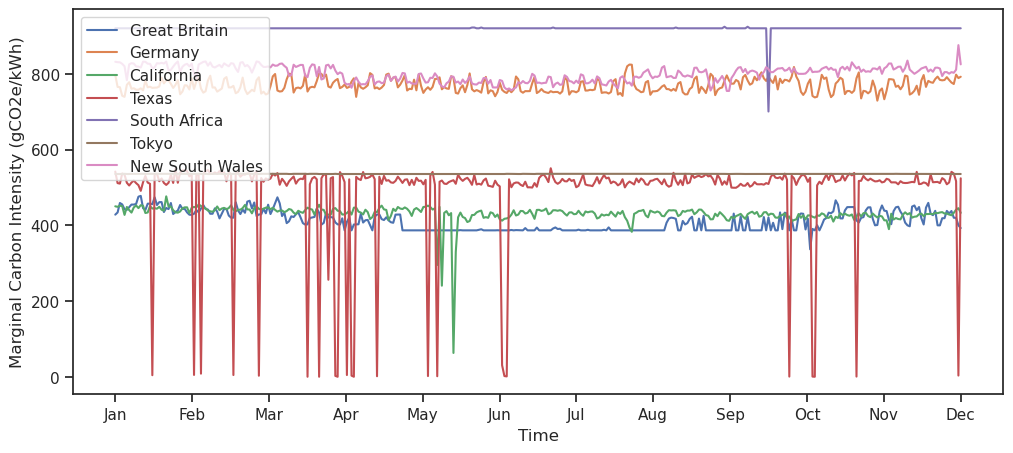

In [ ]:
# Plot Smoothed Regional Comparison
plt.figure(figsize=(12,5))
marg_gb_ci.groupby(['date'])['gb_ci'].median().plot(label='Great Britain')
marg_de_ci.groupby(['date'])['de_ci'].median().plot(label='Germany')
marg_ca_ci.groupby(['date'])['ca_ci'].median().plot(label='California')
marg_tx_ci.groupby(['date'])['tx_ci'].median().plot(label='Texas')
marg_zaf_ci.groupby(['date'])['zaf_ci'].median().plot(label='South Africa')
marg_tyo_ci.groupby(['date'])['tyo_ci'].median().plot(label='Tokyo')
marg_nsw_ci.groupby(['date'])['nsw_ci'].median().plot(label='New South Wales')
plt.legend(loc='upper left')
plt.xticks(np.linspace(0,365,12), short_months)
plt.xlabel('Time')
plt.ylabel('Marginal Carbon Intensity (gCO2e/kWh)')
plt.show()

In [132]:
# Group Data by Days
avg_gb_by_date = gb.groupby(['date'])
avg_de_by_date = de.groupby(['date'])
avg_ca_by_date = ca.groupby(['date'])
avg_tx_by_date = tx.groupby(['date'])
avg_zaf_by_date = zaf.groupby(['date'])
avg_tyo_by_date = tyo.groupby(['date'])
avg_nsw_by_date = nsw.groupby(['date'])

marg_gb_by_date = marg_gb.groupby(['date'])
marg_de_by_date = marg_de.groupby(['date'])
marg_ca_by_date = marg_ca.groupby(['date'])
marg_tx_by_date = marg_tx.groupby(['date'])
marg_zaf_by_date = marg_zaf.groupby(['date'])
marg_tyo_by_date = marg_tyo.groupby(['date'])
marg_nsw_by_date = marg_nsw.groupby(['date'])

In [138]:
# Function to Plot Day comparing all regions
def compare_regions_for_day(signal, selected_date):
    plt.figure(figsize=(8,4))
    # np.roll(marg_region_by_day.get_group(selected_day)['ci'], -(shift * 12))
    if signal == 'avg':
        plt.plot(range(0, 24), np.roll(avg_gb_by_date.get_group(selected_date)['ci'], -gb_shift), label='Great Britain')
        plt.plot(range(0, 24), np.roll(avg_de_by_date.get_group(selected_date)['ci'], -de_shift),label='Germany')
        plt.plot(range(0, 24), np.roll(avg_ca_by_date.get_group(selected_date)['ci'], -ca_shift),label='California')
        plt.plot(range(0, 24), np.roll(avg_tx_by_date.get_group(selected_date)['ci'], -tx_shift),label='Texas')
        plt.plot(range(0, 24), np.roll(avg_zaf_by_date.get_group(selected_date)['ci'], -zaf_shift),label='South Africa')
        plt.plot(range(0, 24), np.roll(avg_tyo_by_date.get_group(selected_date)['ci'], -tyo_shift),label='Tokyo')
        plt.plot(range(0, 24), np.roll(avg_nsw_by_date.get_group(selected_date)['ci'], -nsw_shift),label='New South Wales')

        plt.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
        plt.xticks(ticks=range(0,25), minor=True)
        plt.xticks(ticks=range(0,25,6), labels=range(0,25,6))
        plt.xlabel(selected_date)
        plt.ylabel('Average Carbon Intensity (gCO2e/kWh)')
    else:
        plt.plot(range(0, 288), np.roll(marg_gb_by_date.get_group(selected_date)['ci'], -(gb_shift * 12)), label='Great Britain')
        plt.plot(range(0, 288), np.roll(marg_de_by_date.get_group(selected_date)['ci'], -(ca_shift * 12)),label='Germany')
        plt.plot(range(0, 288), np.roll(marg_ca_by_date.get_group(selected_date)['ci'], -(ca_shift * 12)),label='California')
        plt.plot(range(0, 288), np.roll(marg_tx_by_date.get_group(selected_date)['ci'], -(tx_shift * 12)),label='Texas')
        plt.plot(range(0, 288), np.roll(marg_zaf_by_date.get_group(selected_date)['ci'], -(zaf_shift * 12)),label='South Africa')
        plt.plot(range(0, 288), np.roll(marg_tyo_by_date.get_group(selected_date)['ci'], -(tyo_shift * 12)),label='Tokyo')
        plt.plot(range(0, 288), np.roll(marg_nsw_by_date.get_group(selected_date)['ci'], -(nsw_shift * 12)),label='New South Wales')

        plt.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
        plt.xticks(ticks=range(0,288,12), minor=True)
        plt.xticks(ticks=range(0,289,72), labels=range(0,25,6))
        plt.xlabel(selected_date)
        plt.ylabel('Marginal Carbon Intensity (gCO2e/kWh)')

    plt.show()

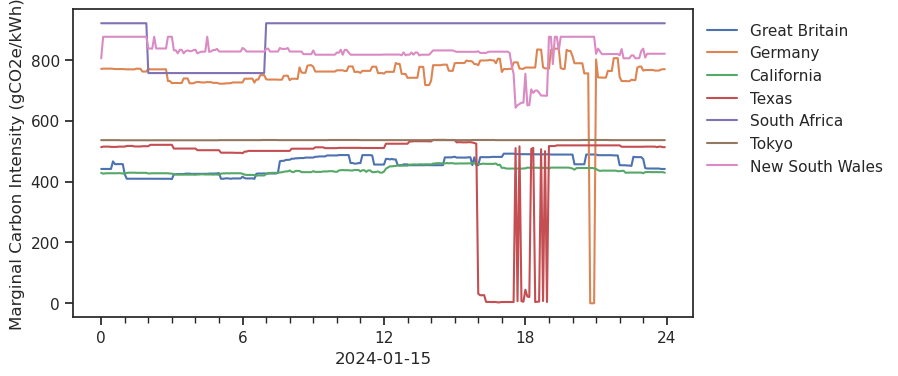

In [139]:
# Plot Shorter Intervals of Marginal Data to highlight brief fluctuation
compare_regions_for_day('marg', '2024-01-15')

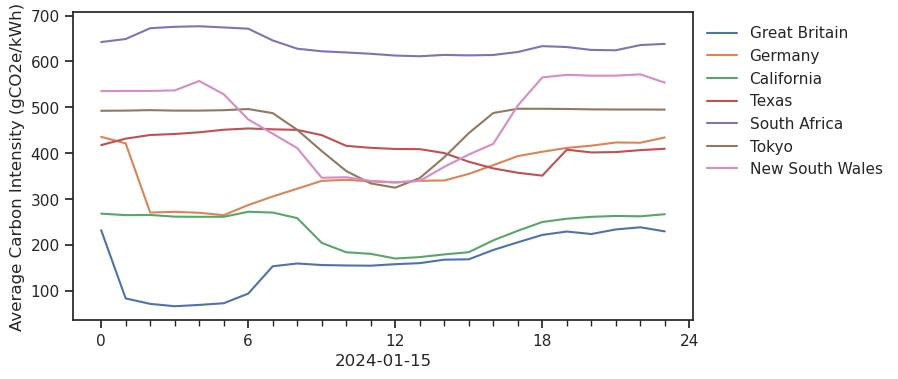

In [140]:
# Plot Shorter Intervals of Average Data to highlight fluctuation / compare with marginal (!)
compare_regions_for_day('avg', '2024-01-15')

In [128]:
# Function to compare the average and marginal signals on a single day for a region
def compare_region_signals_for_day(avg_region_by_day, marg_region_by_day, selected_day, region_name, shift):
    plt.figure(figsize=(8,4))
    plt.plot(range(0, 288), np.roll(marg_region_by_day.get_group(selected_day)['ci'], -(shift * 12)), label='Marginal')
    plt.plot(range(0, 288, 12), np.roll(avg_region_by_day.get_group(selected_day)['ci'], -shift), label='Average')
    plt.legend(bbox_to_anchor=(1.0, 1.0), frameon=False)
    plt.xticks(ticks=range(0,288,12), minor=True)
    plt.xticks(ticks=range(0,289,72), labels=range(0,25,6))
    plt.xlabel(f'{region_name} on {selected_day}')
    plt.ylabel('Carbon Intensity (gCO2e/kWh)')
    plt.show()

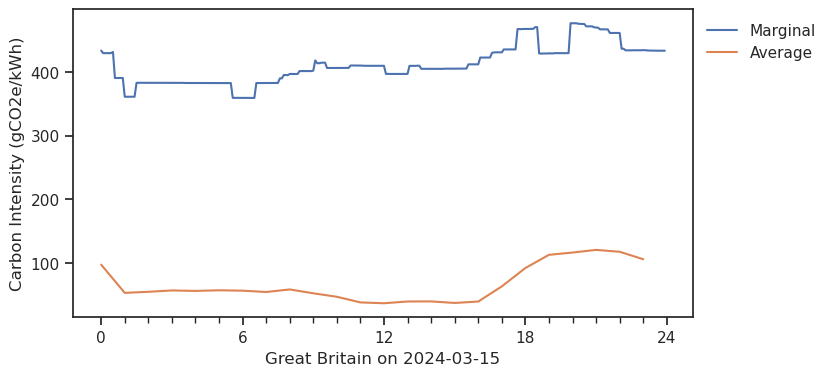

In [148]:
compare_region_signals_for_day(avg_gb_by_date, marg_gb_by_date, '2024-03-15', 'Great Britain', shift=gb_shift)

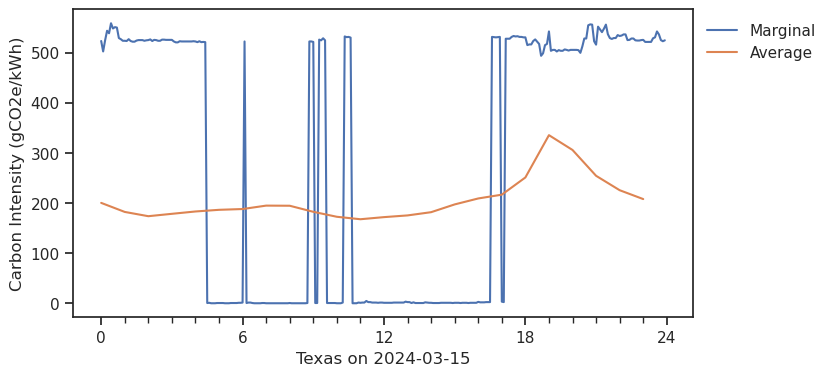

In [147]:
compare_region_signals_for_day(avg_tx_by_date, marg_tx_by_date, '2024-03-15', 'Texas', shift=tx_shift)

**Export CI Data for Shorter Intervals aligning with experiments**
- data is not shifted as it defaults to use UTC data, which is the same as the nextflow traces, which also use utc timestamps, so the data should align as expected

In [55]:
# Export Average CI Data 
def export_avg_carbon_intensity_data_for(df, prefix, start_month, start_day, end_day, year, end_month=None):
    monthly_data = df.groupby('month', as_index=False, sort=False)
    data = []

    if (end_month == None):
        month_data = monthly_data.get_group(start_month).groupby('day', as_index=False, sort=False)
        for day in range(start_day, end_day + 1):
            day_data = month_data.get_group(day).copy()
            #day_data['ci'] = np.roll(day_data['ci'], -shift)
            day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
            data.append(day_data)
    else:
        for current_month in range(start_month, end_month + 1):
            month_data = monthly_data.get_group(current_month).groupby('day', as_index=False, sort=False)

            if current_month < end_month:
                final_day = len(month_data)

                for day in range(start_day, final_day + 1):
                    day_data = month_data.get_group(day).copy()
                    #day_data['ci'] = np.roll(day_data['ci'], -shift)
                    day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
                    data.append(day_data)
            elif current_month == end_month:
                for day in range(1, end_day + 1):
                    day_data = month_data.get_group(day).copy()
                    #day_data['ci'] = np.roll(day_data['ci'], -shift)
                    day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
                    data.append(day_data)

    if end_month == None:
        end_month = start_month

    out_data = pd.concat(data)
    out_data.to_csv(f'../data/intensity/out/{prefix}-{str(start_day).zfill(2)}{str(start_month).zfill(2)}{year}-{str(end_day).zfill(2)}{str(end_month).zfill(2)}{year}.csv', sep=',', index=False, encoding='utf-8', columns=['date', 'start', 'actual'])

In [56]:
# 15/11 - 8/12
export_avg_carbon_intensity_data_for(de, 'de', start_month=11, start_day=15, end_day=8, year=2024, end_month=12)
export_avg_carbon_intensity_data_for(gb, 'gb', start_month=11, start_day=15, end_day=8, year=2024, end_month=12)

In [63]:
# Export Marginal CI Data 
def export_marg_carbon_intensity_data_for(df, prefix, start_month, start_day, end_day, year, end_month=None):
    monthly_data = df.groupby('month', as_index=False, sort=False)
    data = []

    if (end_month == None):
        month_data = monthly_data.get_group(str(start_month).zfill(2)).groupby('day', as_index=False, sort=False)
        for day in range(start_day, end_day + 1):
            day_data = month_data.get_group(str(day).zfill(2)).copy()
            #day_data['ci'] = np.roll(day_data['ci'], -shift)
            day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
            day_data['date'] = day_data['date']
            data.append(day_data)
    else:
        for current_month in range(start_month, end_month + 1):
            month_data = monthly_data.get_group(str(current_month).zfill(2)).groupby('day', as_index=False, sort=False)

            if current_month < end_month:
                final_day = len(month_data)

                for day in range(start_day, final_day + 1):
                    day_data = month_data.get_group(str(day).zfill(2)).copy()
                    #day_data['ci'] = np.roll(day_data['ci'], -shift)
                    day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
                    day_data['date'] = day_data['date']
                    data.append(day_data)
            elif current_month == end_month:
                for day in range(1, end_day + 1):
                    day_data = month_data.get_group(str(day).zfill(2)).copy()
                    #day_data['ci'] = np.roll(day_data['ci'], -shift)
                    day_data = day_data.rename(columns={'hour': 'start', 'ci': 'actual'})
                    day_data['date'] = day_data['date']
                    data.append(day_data)

    if end_month == None:
        end_month = start_month

    out_data = pd.concat(data)
    out_data.to_csv(f'../data/intensity/out/{prefix}-{str(start_day).zfill(2)}{str(start_month).zfill(2)}{year}-{str(end_day).zfill(2)}{str(end_month).zfill(2)}{year}-marg.csv', sep=',', index=False, encoding='utf-8', columns=['date', 'start', 'actual'])

In [64]:
# 01/01 - 31/01
export_marg_carbon_intensity_data_for(marg_tx, 'tx', start_month=1, start_day=1, end_day=31, end_month=1, year=2024)